In [1]:
import pandas as pd
import numpy as np
import duckdb as duck
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing Dtype down allocating data to save memory in this notebook 

In [2]:
def dtype_down_allocating(df: pd.DataFrame) -> pd.DataFrame:
    ini_mb_usage = df.memory_usage().sum() / 1024**2

    f16min, f16max = np.finfo(np.float16).min, np.finfo(np.float16).max
    f32min, f32max = np.finfo(np.float32).min, np.finfo(np.float32).max

    i16min, i16max = np.iinfo(np.int16).min, np.iinfo(np.int16).max
    i32min, i32max = np.iinfo(np.int32).min, np.iinfo(np.int32).max

    for col in df.columns:
        col_dtype = df[col].dtype

        if pd.api.types.is_numeric_dtype(col_dtype):
            col_max = df[col].max()
            col_min = df[col].min()

            if pd.api.types.is_float_dtype(col_dtype):
                if col_min >= f16min and col_max <= f16max:
                    df[col] = df[col].astype(np.float16)
                elif col_min >= f32min and col_max <= f32max:
                    df[col] = df[col].astype(np.float32)

            elif pd.api.types.is_integer_dtype(col_dtype):
                if col_min >= i16min and col_max <= i16max:
                    df[col] = df[col].astype(np.int16)
                elif col_min >= i32min and col_max <= i32max:
                    df[col] = df[col].astype(np.int32)
                
    end_mb_usage = (df.memory_usage().sum() / 1024**2) *100
    
    print(f'{np.round((end_mb_usage-ini_mb_usage)/ini_mb_usage, 2)}%')
        
    return df

# Kaggle Dataset Summary

"Can you use movement, temperature, and proximity sensor data to differentiate between body-focused repetitive behaviors (BFRBs), like hair pulling, from non-BFRB everyday gestures, like adjusting glasses? The goal of this competition is to develop a predictive model that distinguishes BFRB-like and non-BFRB-like activity using data from a variety of sensors collected via a wrist-worn device. Successfully disentangling these behaviors will improve the design and accuracy of wearable BFRB-detection devices, which are relevant to a wide range of mental illnesses, ultimately strengthening the tools available to support their treatment."



### Body-focused repetitive behaviors (BFRBs)
Body-focused repetitive behaviors (BFRBs), such as hair pulling, skin picking, and nail biting, are self-directed habits involving repetitive actions that, when frequent or intense, can cause physical harm and psychosocial challenges. These behaviors are commonly seen in anxiety disorders and obsessive-compulsive disorder (OCD), thus representing key indicators of mental health challenges.

### Sensors
TOF : Time of Fligh (Proximity)<br>
TMP : Thermopile (Temperature)<br>
IMU : Inertial Measurement Unit (Movement and rotation)<br>

![image.png](Images/Sensor_Img.jpg)

``row_id``<br>
``sequence_id`` - An ID for the batch of sensor data. Each sequence includes one Transition, one Pause, and one Gesture.<br>
``sequence_type`` - If the gesture is a target or non-target type. **Train only**.<br>
``sequence_counter`` - A counter of the row within each sequence.<br>
``subject`` - A unique ID for the subject who provided the data.<br>
``gesture`` - The target column. Description of sequence Gesture. **Train only**.<br>
``orientation`` - Description of the subject's orientation during the sequence. **Train only**.<br>
``behavior`` - A description of the subject's behavior during the current phase of the sequence.<br>
``acc_[x/y/z]`` - Measure linear acceleration along three axes in meters per second squared from the IMU sensor.<br>
``rot_[w/x/y/z]``- Orientation data which combines information from the IMU's gyroscope, accelerometer, and magnetometer to describe the device's orientation in 3D space.<br>
``thm_[1-5]`` - There are five thermopile sensors on the watch which record temperature in degrees Celsius. Note that the index/number for each corresponds to the index in the photo on the Overview tab.<br>
``tof_[1-5]_v[0-63]`` - There are five time-of-flight sensors on the watch that measure distance. In the dataset, the 0th pixel for the first time-of-flight sensor can be found with column name tof_1_v0, whereas the final pixel in the grid can be found under column<br>
``tof_1_v63``. This data is collected row-wise, where the first pixel could be considered in the top-left of the grid, with the second to its right, ultimately wrapping so the final value is in the bottom right (see image above). The particular time-of-flight sensor is denoted by the number at the start of the column name (e.g., 1_v0 is the first pixel for the first time-of-flight sensor while 5_v0 is the first pixel for the fifth time-of-flight sensor). If there is no sensor response (e.g., if there is no nearby object causing a signal reflection), a -1 is present in this field. Units are uncalibrated sensor values in the range 0-254. Each sensor contains 64 pixels arranged in an 8x8 grid, visualized in the figure below.

In [3]:
train_df = dtype_down_allocating(pd.read_csv(r"../../data/CMI_Sensor_Data/train.csv"))
test_df = dtype_down_allocating(pd.read_csv(r"../../data/CMI_Sensor_Data/test.csv"))
train_demo = pd.read_csv(r"../../data/CMI_Sensor_Data/train_demographics.csv")
test_demo = pd.read_csv(r"../../data/CMI_Sensor_Data/test_demographics.csv")

25.76%
24.7%


In [4]:
train = train_df.merge(right=train_demo,how='left',on=['subject'])

# Dataset Demographics Data Analysis 

## Gender Demographics

- The predominant gender in the training data is **Male**, representing **60.02%** of the total.
  - When we split by age group:
    - Among **adults**, **78%** are male.
    - Among **children**, **58%** are **female**.

In [6]:
sex = { 
    0: 'Female',
    1: 'Male'
}
sex_colors = {
    'Female': "#002EC4",
    'Male': "#2e005c" 
}

adult_child = {
    0: "Child",
    1: "Adult"
}

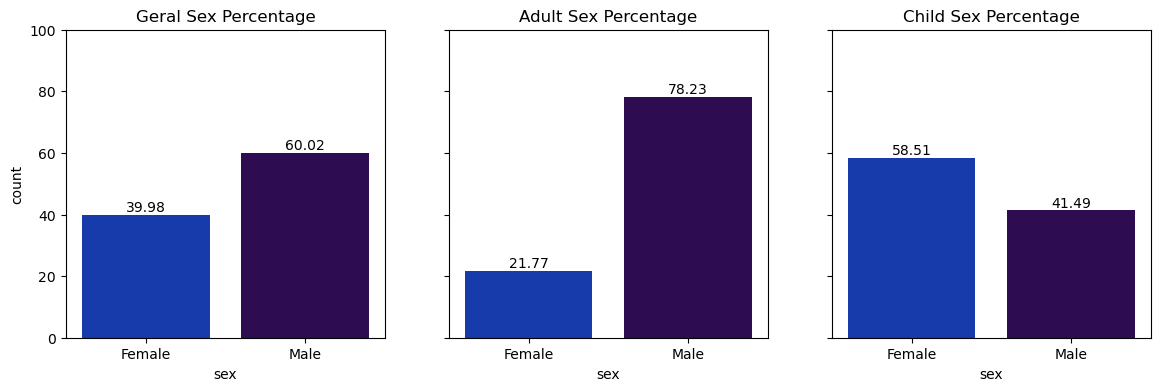

In [7]:
sex_pct = pd.DataFrame((round((train['sex'].value_counts() / train['sex'].value_counts().sum()) *100,2))).reset_index().sort_values(by='sex', ascending=True)
sex_pct['sex'] = sex_pct['sex'].map(sex)
child_sex_pct =pd.DataFrame(round(train[train['adult_child'] == 0]['sex'].value_counts() / train[train['adult_child'] == 0]['sex'].value_counts().sum()*100,2)).reset_index().sort_values(by='sex', ascending=True)
child_sex_pct['sex'] = child_sex_pct['sex'].map(sex)
adult_sex_pct =pd.DataFrame(round(train[train['adult_child'] == 1]['sex'].value_counts() / train[train['adult_child'] == 1]['sex'].value_counts().sum()*100,2)).reset_index().sort_values(by='sex', ascending=True)
adult_sex_pct['sex'] = adult_sex_pct['sex'].map(sex)

fig, ax = plt.subplots(1,3, figsize=(14,4), sharey=True)

sns.barplot(sex_pct, x='sex', y='count', hue='sex',ax=ax[0], palette=sex_colors)
ax[0].set_title("Geral Sex Percentage")

sns.barplot(adult_sex_pct, x='sex', y='count', hue='sex',ax=ax[1],palette=sex_colors)
ax[1].set_title("Adult Sex Percentage")

sns.barplot(child_sex_pct, x='sex', y='count', hue='sex',ax=ax[2], palette=sex_colors)
ax[2].set_title("Child Sex Percentage")
plt.ylim(0,100)

for idx in range(3):
    for container in ax[idx].containers:
        ax[idx].bar_label(container)

<Axes: xlabel='age', ylabel='count'>

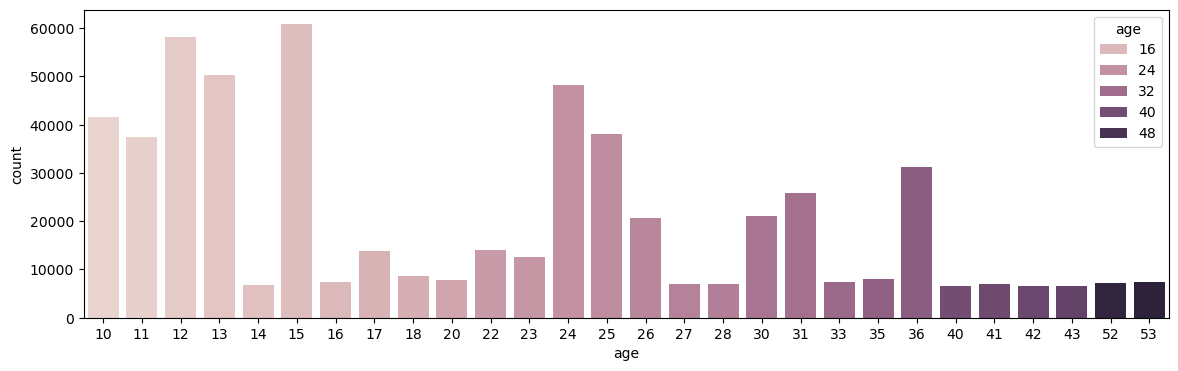

In [69]:
plt.figure(figsize=(14,4))
age_sparse = train.groupby("age").size().reset_index(name='count')
age_sparse['count_pct'] = (age_sparse['count'] / age_sparse['count'].sum()) * 100 
sns.barplot(age_sparse, x='age', y='count', hue='age' ,)

#### Search for patterns by sex

In [82]:
sex

{0: 'Female', 1: 'Male'}

In [85]:
train[train['gesture'] == "Eyelash - pull hair" ]['sex'].value_counts().reset_index()

,sex,count
0,1,23822
1,0,16396


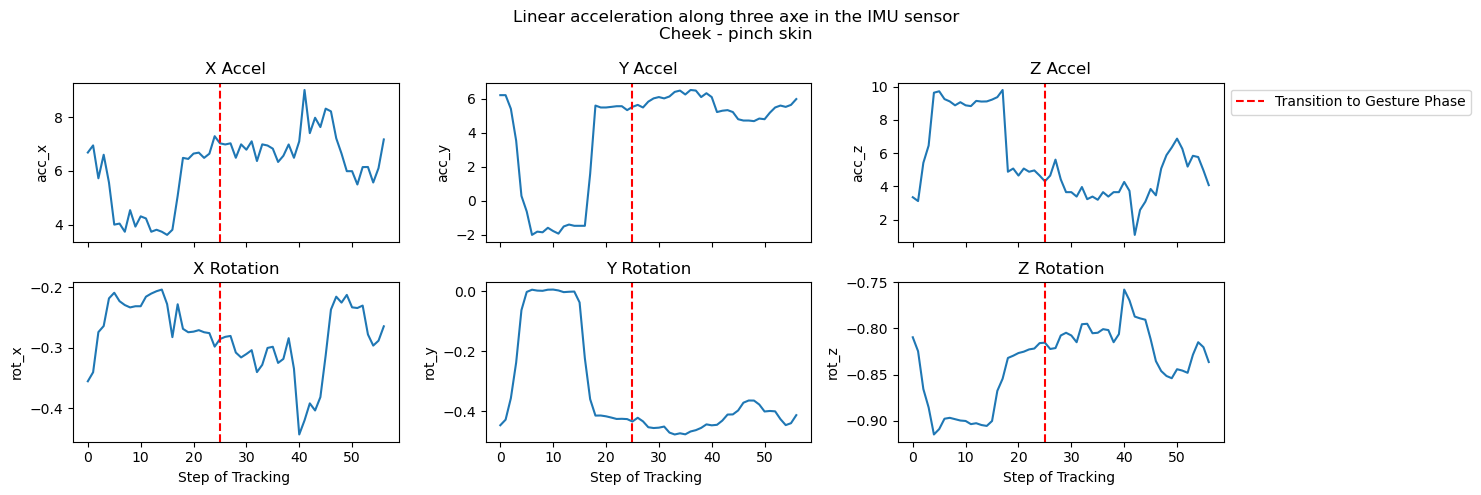

In [174]:
fig, ax = plt.subplots(2,3, figsize=(15,5), sharex=True)
fig.suptitle(f"Linear acceleration along three axe in the IMU sensor\n{train.iloc[1]['gesture']}")
gesture_idx = train.iloc[:57][train['phase'].iloc[:57] == 'Gesture'].index[0]

sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="acc_x", ax=ax[0,0])
ax[0,0].axvline(x=gesture_idx, color='red', linestyle='--')
ax[0,0].set_xlabel("Step of Tracking ")
ax[0,0].set_title("X Accel")
#ax[0].legend()

sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="acc_y", ax=ax[0,1] )
ax[0,1].axvline(x=gesture_idx, color='red', linestyle='--')
ax[0,1].set_title("Y Accel")
ax[0,1].set_xlabel("Step of Tracking ")

sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="acc_z" , ax=ax[0,2])
ax[0,2].axvline(x=gesture_idx, color='red', linestyle='--', label="Transition to Gesture Phase")
ax[0,2].set_title("Z Accel")
ax[0,2].set_xlabel("Step of Tracking ")
ax[0,2].legend(loc='upper left', bbox_to_anchor=(1, 1))


sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="rot_x" , ax=ax[1,0])
ax[1,0].axvline(x=gesture_idx, color='red', linestyle='--')
ax[1,0].set_title("X Rotation")
ax[1,0].set_xlabel("Step of Tracking ")

sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="rot_y" , ax=ax[1,1])
ax[1,1].axvline(x=gesture_idx, color='red', linestyle='--')
ax[1,1].set_title("Y Rotation")
ax[1,1].set_xlabel("Step of Tracking ")

sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y="rot_z" , ax=ax[1,2])
ax[1,2].axvline(x=gesture_idx, color='red', linestyle='--')
ax[1,2].set_title("Z Rotation")
ax[1,2].set_xlabel("Step of Tracking ")


plt.tight_layout()
plt.show()

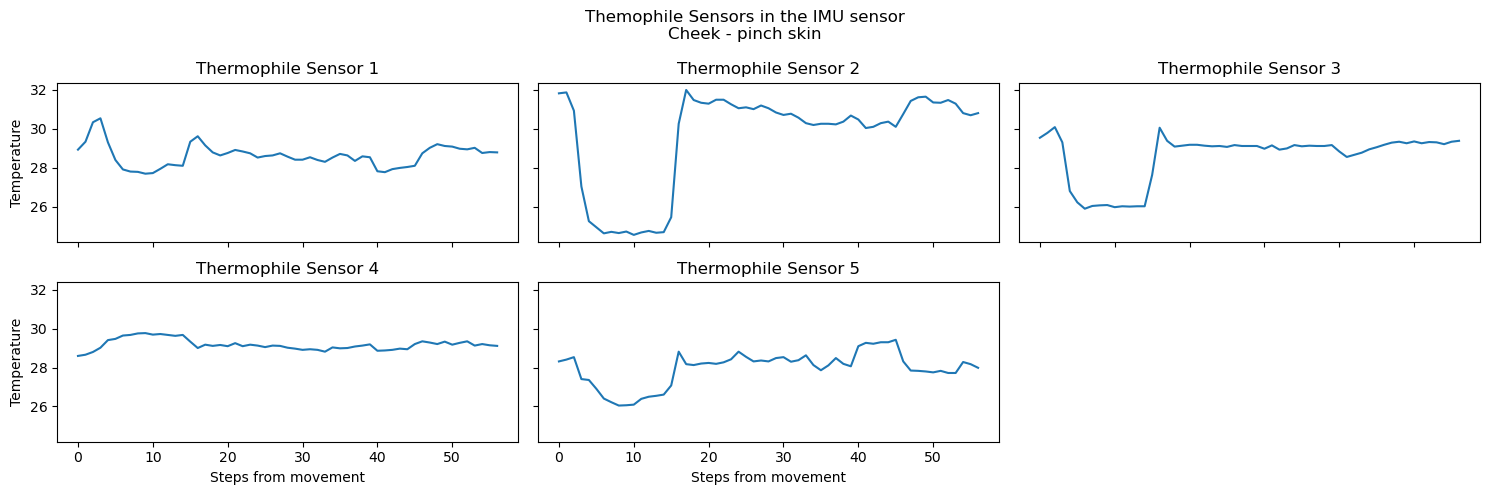

In [195]:
fig,ax = plt.subplots(2,3, figsize=(15,5),sharex=True, sharey=True)
fig.suptitle(f"Themophile Sensors in the IMU sensor\n{train.iloc[1]['gesture']}")
a = 0
j = 0
ax[1,2].remove()
for i in range(5):
    if j == 3:
        j = 0
        a =+1
    sns.lineplot(train.iloc[:57],x=train.iloc[:57].index, y=f'thm_{i+1}', ax=ax[a,j])
    ax[a,j].set_title(f"Thermophile Sensor {i+1}")
    ax[a,j].set_xlabel(f"Steps from movement")
    ax[a,j].set_ylabel(f"Temperature")
    j +=1

plt.tight_layout()
plt.show()

In [73]:
train.gesture.unique()

array(['Cheek - pinch skin', 'Forehead - pull hairline',
       'Write name on leg', 'Feel around in tray and pull out an object',
       'Neck - scratch', 'Neck - pinch skin', 'Eyelash - pull hair',
       'Eyebrow - pull hair', 'Forehead - scratch',
       'Above ear - pull hair', 'Wave hello', 'Write name in air',
       'Text on phone', 'Pull air toward your face',
       'Pinch knee/leg skin', 'Scratch knee/leg skin',
       'Drink from bottle/cup', 'Glasses on/off'], dtype=object)

In [ ]:
train_df[['age']].groupby(by=['age']).size()
sns.barplot(train_df,)

In [8]:
tof_columns = [col for col in train.columns if col.startswith('tof')]
tof_array = train[tof_columns].values
tof_images = tof_array.reshape(-1, 5, 8, 8)
print(tof_images.shape) 

(574945, 5, 8, 8)


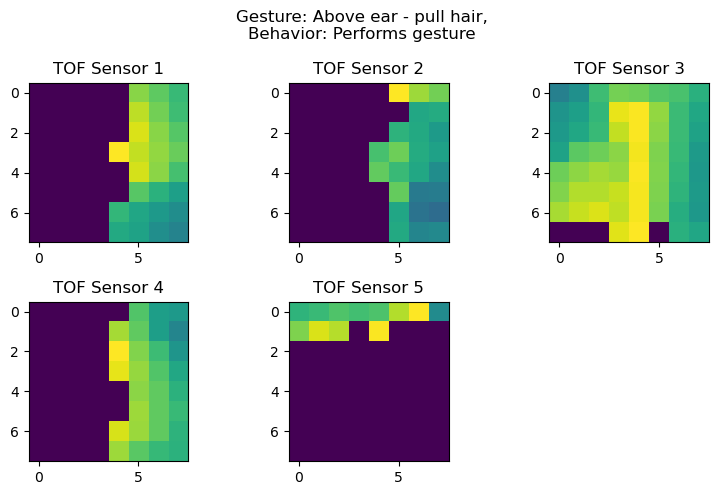

In [26]:
img_idx = 5024
fig,ax = plt.subplots(2,3, figsize=(8,5))

plt.suptitle(f"Gesture: {train['gesture'].iloc[img_idx]},\nBehavior: {train['behavior'].iloc[img_idx]}")
ax[0,0].imshow(tof_images[img_idx][0])
ax[0,0].set_title("TOF Sensor 1")
ax[0,1].imshow(tof_images[img_idx][1])
ax[0,1].set_title("TOF Sensor 2")
ax[0,2].imshow(tof_images[img_idx][2])
ax[0,2].set_title("TOF Sensor 3")
ax[1,0].imshow(tof_images[img_idx][3])
ax[1,0].set_title("TOF Sensor 4")
ax[1,1].imshow(tof_images[img_idx][4])
ax[1,1].set_title("TOF Sensor 5")
ax[1,2].remove()

plt.tight_layout()
plt.show()